In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import time
import collections
from collections import Counter
pd.set_option("display.max_colwidth", None)

In [2]:
df = pd.read_csv('cleaned_df.csv')
print(df.shape)
df.head()

(1681, 19)


,subreddit,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,banned_by,author,url,score,upvote_ratio,text,stopwords,punctuation,hastags,numerics,upper
0,Meditation,Massive announcement concerning the future of ...,Now that I have burned all the past karma that...,True,0,1640907530,2021-12-31 07:38:50,NaN,NaN,Extension_Mouse686,https://www.reddit.com/r/Meditation/comments/r...,1,1.0,massive announcement concern future human spec...,415,54,0,4,31
1,Meditation,Meditation Technique to deal with the first mi...,I have been meditating for 220 consecutive day...,True,0,1640903751,2021-12-31 06:35:51,NaN,NaN,hartmanners,https://www.reddit.com/r/Meditation/comments/r...,1,1.0,technique deal first minute noisy mind 220 con...,155,30,0,2,6
2,Meditation,What should I focus on if I’m meditating witho...,I’ve tried to make meditation a part of my dai...,True,0,1640898514,2021-12-31 05:08:34,NaN,NaN,v_philosoph,https://www.reddit.com/r/Meditation/comments/r...,1,1.0,focus without video guide try make part daily ...,52,8,0,0,9
3,Meditation,"Racing mind, adhd?",I have periods during the day where my mind is...,True,0,1640896254,2021-12-31 04:30:54,NaN,NaN,chris152772272727829,https://www.reddit.com/r/Meditation/comments/r...,1,1.0,race mind adhd period day mind race thought ad...,18,7,0,0,1
4,Meditation,Is there such a thing as “spiritual meditation...,I think I’ve been meditating correctly for a w...,True,0,1640895782,2021-12-31 04:23:02,NaN,NaN,OkStep3679,https://www.reddit.com/r/Meditation/comments/r...,1,1.0,thing spiritual v think correctly never consis...,44,6,0,0,4


In [3]:
# dummifying for yoga
df['yoga'] = [1 if value=='yoga' else 0 for value in df['subreddit'].values]

## Train-Test Split

In [4]:
X = df['text']
y = df['yoga']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = df['subreddit'])
print(f'Train dimensions: {X_train.shape, y_train.shape}')
print(f'Test dimensions: {X_test.shape, y_test.shape}')
# Check out target distribution
print(y_train.value_counts())
print(y_test.value_counts())

Train dimensions: ((1176,), (1176,))
Test dimensions: ((505,), (505,))
0    690
1    486
Name: yoga, dtype: int64
0    296
1    209
Name: yoga, dtype: int64


Due to imbalanced classes, we need to stratify the data when we split them into training and testing sets.

## Baseline Model
As the original dataset extracted equal number of submissions from each subreddit, the baseline score would be 0.5 (50-50 chance of guessing if a post is from r/yoga or r/Meditation).

In [6]:
df['subreddit'].value_counts()

Meditation    986
yoga          695
Name: subreddit, dtype: int64

In [7]:
695/1681

0.4134443783462225

After cleaning, r/yoga submissions consisted of ~40% of the dataset and r/Meditation making up ~60%. Taking the higher percentage of guessing one subreddit (aka r/Meditation) correctly, due to more posts, the baseline score would now be 0.6. Either way, any model that have an accuracy score of more than 0.6 would (and probably should) outperform this baseline score.

## Setting up pipelines and gridsearch parameters

In [8]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=500))
])

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=500))
])

pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
    'tvec__max_features':[2_000, 3_000, 4_000, 5_000],
    'tvec__min_df': [2, 3, 5, 10],
    'tvec__max_df': np.linspace(0.8, 1, 4),
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__stop_words': [None, 'english']
}

# Setting params for CountVectorizer gridsearch
cv_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3, 5, 10],
    'cvec__max_df': np.linspace(0.8, 1, 4),
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words' : [None, 'english']
}

# Setting up randomforest params
rf_params = {
    'rf__max_depth': [1000],
    'rf__min_samples_split': [100],
    'rf__max_leaf_nodes': [None]
}

### Model 1
CountVectorizer + Logistic Regression

In [9]:
start = time.time()
gs1 = GridSearchCV(pipe1, param_grid=cv_params, cv=5, n_jobs=-1)
cv_lr = gs1.fit(X_train, y_train)
end = time.time()
print(end - start)

138.81270003318787


In [10]:
print('best score:', cv_lr.best_score_)
print('best params:', cv_lr.best_params_)
print('train score:', cv_lr.score(X_train, y_train))
print('test score:', cv_lr.score(X_test, y_test))

best score: 0.8563000360620266
best params: {'cvec__max_df': 0.8, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
train score: 0.9974489795918368
test score: 0.8792079207920792


### Model 2
TF-IDFVectorizer + Logistic Regression

In [11]:
start = time.time()
gs2 = GridSearchCV(pipe2, param_grid=tf_params, cv=5, n_jobs=-1)
tv_lr = gs2.fit(X_train, y_train)
end = time.time()
print(end - start)

136.00186491012573


In [12]:
print('best score:', tv_lr.best_score_)
print('best params:', tv_lr.best_params_)
print('train score:', tv_lr.score(X_train, y_train))
print('test score:', tv_lr.score(X_test, y_test))

best score: 0.8664983772087991
best params: {'tvec__max_df': 0.8, 'tvec__max_features': 2000, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
train score: 0.9447278911564626
test score: 0.8693069306930693


### Model 3
CountVectorizer + MultinomialNB Classification

In [13]:
start = time.time()
gs3 = GridSearchCV(pipe3, param_grid=cv_params, cv=5, n_jobs=-1)
cv_nb = gs3.fit(X_train, y_train)
end = time.time()
print(end - start)

106.54118585586548


In [14]:
print('best score:', cv_nb.best_score_)
print('best params:', cv_nb.best_params_)
print('train score:', cv_nb.score(X_train, y_train))
print('test score:', cv_nb.score(X_test, y_test))

best score: 0.8613919942300757
best params: {'cvec__max_df': 0.8, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
train score: 0.9311224489795918
test score: 0.8871287128712871


cvec__max_df': 0.1

### Model 4
TF-IDFVectorizer + MultinomialNB Classification

In [15]:
start = time.time()
gs4 = GridSearchCV(pipe4, param_grid=tf_params, cv=5, n_jobs=-1)
tv_nb = gs4.fit(X_train, y_train)
end = time.time()
print(end - start)

106.76011919975281


In [16]:
print('best score:', tv_nb.best_score_)
print('best params:', tv_nb.best_params_)
print('train score:', tv_nb.score(X_train, y_train))
print('test score:', tv_nb.score(X_test, y_test))

best score: 0.8749909844933285
best params: {'tvec__max_df': 0.8, 'tvec__max_features': 2000, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
train score: 0.9251700680272109
test score: 0.8693069306930693


### Model 5
CountVectorizer + Random Forest

In [17]:
start = time.time()
gs5 = GridSearchCV(pipe5, param_grid={**cv_params,**rf_params}, cv=5, n_jobs=-1)
cv_rf = gs5.fit(X_train, y_train)
end = time.time()
print(end - start)

262.7599427700043


In [18]:
print('best score:', cv_rf.best_score_)
print('best params:', cv_rf.best_params_)
print('train score:', cv_rf.score(X_train, y_train))
print('test score:', cv_rf.score(X_test, y_test))

best score: 0.8622286332491887
best params: {'cvec__max_df': 1.0, 'cvec__max_features': 2000, 'cvec__min_df': 10, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': 1000, 'rf__max_leaf_nodes': None, 'rf__min_samples_split': 100}
train score: 0.9302721088435374
test score: 0.8574257425742574


### Model 6
TF-IDFVectorizer + Random Forest

In [19]:
start = time.time()
gs6 = GridSearchCV(pipe6, param_grid={**tf_params,**rf_params}, cv=5, n_jobs=-1)
tv_rf = gs6.fit(X_train, y_train)
end = time.time()
print(end - start)

292.966046333313


In [20]:
print('best score:', tv_rf.best_score_)
print('best params:', tv_rf.best_params_)
print('train score:', tv_rf.score(X_train, y_train))
print('test score:', tv_rf.score(X_test, y_test))

best score: 0.863079697078976
best params: {'rf__max_depth': 1000, 'rf__max_leaf_nodes': None, 'rf__min_samples_split': 100, 'tvec__max_df': 0.8666666666666667, 'tvec__max_features': 4000, 'tvec__min_df': 10, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
train score: 0.9600340136054422
test score: 0.8554455445544554


## Comparing Models

In [21]:
pred1 = cv_lr.predict(X_test)
pred2 = tv_lr.predict(X_test)
pred3 = cv_nb.predict(X_test)
pred4 = tv_nb.predict(X_test)
pred5 = cv_rf.predict(X_test)
pred6 = tv_rf.predict(X_test)

tn1, fp1, fn1, tp1 = confusion_matrix(y_test, pred1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, pred2).ravel()
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, pred3).ravel()
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, pred4).ravel()
tn5, fp5, fn5, tp5 = confusion_matrix(y_test, pred5).ravel()
tn6, fp6, fn6, tp6 = confusion_matrix(y_test, pred6).ravel()

In [41]:
results = {'Model': ['cvec + lr', 'tvec + lr', 'cvec + nb', 'tvec + nb', 'cvec + rf', 'tvec + rf'],
           'accuracy_train': [cv_lr.score(X_train, y_train), tv_lr.score(X_train, y_train), 
                              cv_nb.score(X_train, y_train), tv_nb.score(X_train, y_train), 
                              cv_rf.score(X_train, y_train), tv_rf.score(X_train, y_train)],
           'accuracy_test': [cv_lr.score(X_test, y_test), tv_lr.score(X_test, y_test), 
                              cv_nb.score(X_test, y_test), tv_nb.score(X_test, y_test), 
                              cv_rf.score(X_test, y_test), tv_rf.score(X_test, y_test)],
           'recall': [recall_score(y_test, pred1), recall_score(y_test, pred2), 
                      recall_score(y_test, pred3), recall_score(y_test, pred4), 
                      recall_score(y_test, pred5), recall_score(y_test, pred6)],
           'f1': [f1_score(y_test, pred1), f1_score(y_test, pred2), 
                  f1_score(y_test, pred3), f1_score(y_test, pred4),  
                  f1_score(y_test, pred5), f1_score(y_test, pred6)],
           'true_neg': [tn1, tn2, tn3, tn4, tn5, tn6],
           'false_pos': [fp1, fp2, fp3, fp4, fp5, fp6],
           'false_neg': [fn1, fn2, fn3, fn4, fn5, fn6],
           'true_pos': [tp1, tp2, tp3, tp4, tp5, tp6],  
        }

results_df = pd.DataFrame(results, index=['model_1','model_2','model_3','model_4','model_5','model_6'])

results_df.insert(3,'score_diff',results_df['accuracy_train']-results_df['accuracy_test'])

results_df

,Model,accuracy_train,accuracy_test,score_diff,recall,f1,true_neg,false_pos,false_neg,true_pos
model_1,cvec + lr,0.997449,0.879208,0.118241,0.784689,0.843188,280,16,45,164
model_2,tvec + lr,0.944728,0.869307,0.075421,0.717703,0.819672,289,7,59,150
model_3,cvec + nb,0.931122,0.887129,0.043994,0.837321,0.859951,273,23,34,175
model_4,tvec + nb,0.925170,0.869307,0.055863,0.727273,0.821622,287,9,57,152
model_5,cvec + rf,0.930272,0.857426,0.072846,0.679426,0.797753,291,5,67,142
model_6,tvec + rf,0.960034,0.855446,0.104588,0.688995,0.797784,288,8,65,144


All the test sets have lower accuracy score than the train set. This would mean the model is overfit hence the model could not predict as well for the test set as compared to the train set. The model with the lowest difference in score is **Model 3 - Countvectorizer and Multinomial NB classification**. 

Our aim is to maximise the true positives. The recall score would tell us the number of true positives over actual positives. Model 3 also has the **highest recall score** and **highest f1 score** (balance with precision (true positive/predicted positive) and recall). We can note that the Type I and Type II errors are more balanced for this model. Hence, model 3 was chosen.

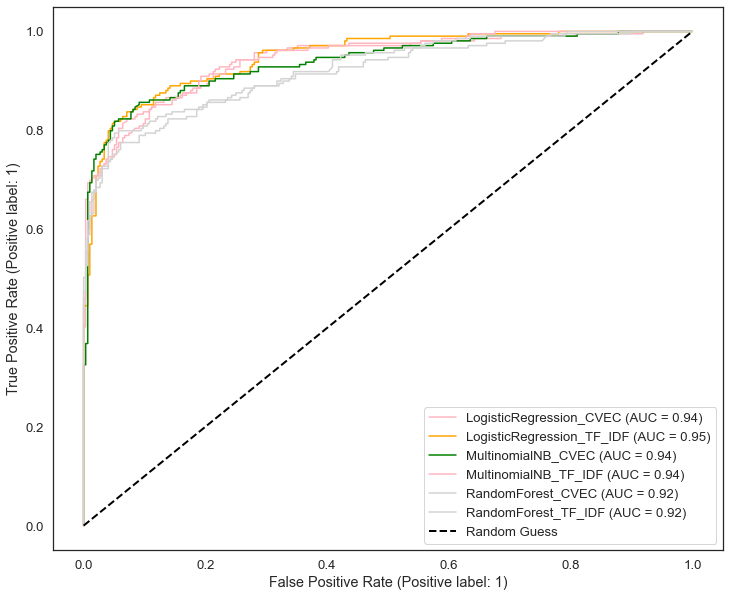

In [44]:
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(cv_lr, X_test, y_test, ax=ax, name='LogisticRegression_CVEC', color='lightpink')
plot_roc_curve(tv_lr, X_test, y_test, ax=ax, name='LogisticRegression_TF_IDF', color='orange')
plot_roc_curve(cv_nb, X_test, y_test, ax=ax, name='MultinomialNB_CVEC', color='green')
plot_roc_curve(tv_nb, X_test, y_test, ax=ax, name='MultinomialNB_TF_IDF', color='lightpink')
plot_roc_curve(cv_rf, X_test, y_test, ax=ax, name='RandomForest_CVEC', color='lightgrey')
plot_roc_curve(tv_rf, X_test, y_test, ax=ax, name='RandomForest_TF_IDF', color='lightgrey')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend();

When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. 
The AUC-ROC curve shows that the logistic regression models and multinomial NB models have high AUC. All 4 models AUC are very close with Model 2 having a slightly higher AUC. Nonetheless, Model 3 is preferred due to the reasons mentioned above.

# Interpretation of results
## Top Predicted Words

In [24]:
cv_nb_df = pd.DataFrame(cv_nb.best_estimator_.steps[0][1].get_feature_names(), columns = ['word'])
cv_nb_df['yoga_proba'] = pd.Series(np.exp(cv_nb.best_estimator_.named_steps.nb.feature_log_prob_[1]))
cv_nb_df['Meditation_proba'] = pd.Series(np.exp(cv_nb.best_estimator_.named_steps.nb.feature_log_prob_[0]))
cv_nb_df.T

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
word,10,100,1000,1015,1020,10day,10min,11,12,13,...,younger,youtube,youve,yr,yt,ytt,zen,zero,zone,zoom
yoga_proba,0.000661,0.000331,0.000041,0.000124,0.000041,0.000041,0.000083,0.000083,0.000331,0.000165,...,0.000124,0.001653,0.000207,0.000165,0.000207,0.000372,0.000083,0.000207,0.000083,0.000372
Meditation_proba,0.000809,0.000303,0.000101,0.000101,0.000076,0.000126,0.000076,0.000051,0.000177,0.000025,...,0.000051,0.000657,0.000227,0.000025,0.000025,0.000025,0.000809,0.000202,0.000253,0.000076


In [25]:
top_yoga = cv_nb_df.sort_values(by='yoga_proba', ascending=False)
top_Meditation = cv_nb_df.sort_values(by='Meditation_proba', ascending=False)

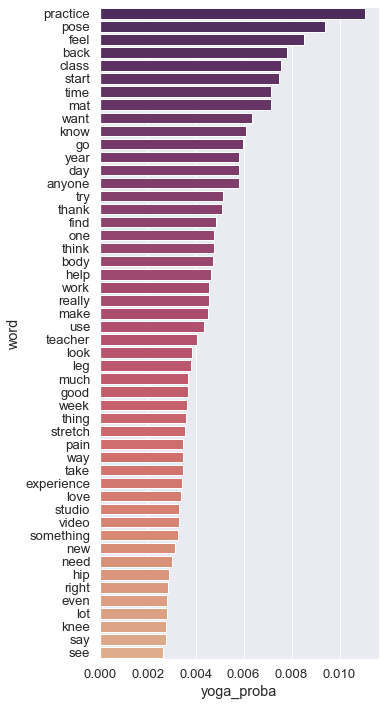

In [55]:
plt.figure(figsize=(5,12))
sns.set(font_scale = 1.2)
ax1 = sns.barplot(x="yoga_proba", y="word", data=top_yoga.head(50), palette='flare_r')
## Tried to add horizontal bar values but my matplotlib too old
# Label with specially formatted floats
# ax.bar_label(hbars, fmt='%.2f')
# ax.set_xlim(right=15)

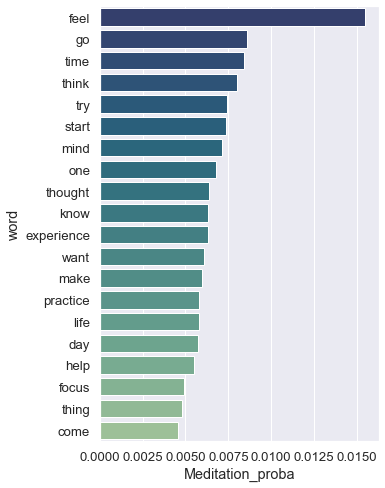

In [27]:
plt.figure(figsize=(5,8))
sns.set(font_scale = 1.2)
ax2 = sns.barplot(x="Meditation_proba", y="word", data=top_Meditation.head(20), palette='crest_r')

As seen in the previous notebook on EDA, the top ngrams explored then have made their way into the top predictors for each subreddit. Different common predictors could be identified to be aligned to one subreddit over the other. Words like 'practice' had higher probability to be classified under r/yoga while words like 'time' was identified for meditation.

In [63]:
df['text'].loc[(df['subreddit']=='yoga')&(df['text'].str.contains('pain'))].head(20)

988                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [64]:
df['text'].loc[(df['subreddit']=='yoga')&(df['text'].str.contains('video'))].head(20)

992                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

For r/yoga, top predictors also include words like 'pain' and most arose from the context of incorrect yoga posture during self practice. This is another hit point we can target by having consults on correct yoga poses and having additional co-instructors for in-person classes to correct mistakes.

Yoga enthusiasts also like to reference yoga videos and it would be helpful if we could also offer recordings of live sessions.

In [28]:
top_yoga_pred = top_yoga['word'].head(30).tolist()
top_Meditation_pred = top_Meditation['word'].head(30).tolist()

yoga_multiset = collections.Counter(top_yoga_pred)
Meditation_multiset = collections.Counter(top_Meditation_pred)

overlap = list((yoga_multiset & Meditation_multiset).elements())
yoga_remainder = list((yoga_multiset - Meditation_multiset).elements())
Meditation_remainder = list((Meditation_multiset - yoga_multiset).elements())

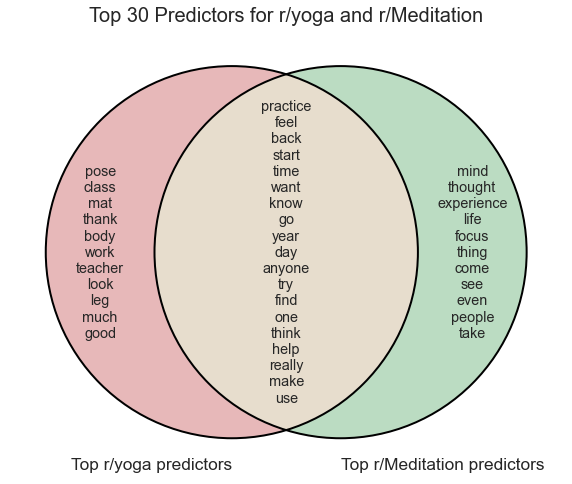

In [29]:
# setup the figure
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title('Top 30 Predictors for r/yoga and r/Meditation', fontsize=20)
# make the venn diagram
v = venn2([set(top_yoga['word'].head(30)), set(top_Meditation['word'].head(30))],
set_labels=['Top r/yoga predictors', 'Top r/Meditation predictors'])
# adjust labels from counts to names
v.get_label_by_id('10').set_text('\n'.join(yoga_remainder))
v.get_label_by_id('01').set_text('\n'.join(Meditation_remainder))
v.get_label_by_id('11').set_text('\n'.join(overlap))
# add circle outlines
c = venn2_circles([set(top_yoga['word'].head(30)), set(top_Meditation['word'].head(30))],
                  linestyle='solid')

These keywords would be useful to identify the needs and wants of yoga enthusiasts who have more focus on the yoga poses, teachers & classes and exercise equipment like mats. Perhaps the marketing campaign could consider giving free mats for first-time subscribers. There is also higher emphasis on the body and yoga as an active form of meditation could be another keyword to tailor ads.

The common predictors would require more thought and investigation for context as the words are general and neutral. 

## Top Predicted Posts

In [30]:
predictions = pd.DataFrame(cv_nb.predict_proba(X))
predictions['text'] = df['text']

In [31]:
predictions.columns = ['Meditation', 'yoga', 'text']

In [33]:
# Top predicted r/yoga posts
predictions.sort_values('yoga', ascending=False)[:15]

,Meditation,yoga,text
1340,2.242943e-15,1.0,happy baby pose sacrum hi month always struggl...
1137,3.046878e-17,1.0,need reasonably price mat high level pad curre...
1045,7.861738e-15,1.0,byoga strong mat byoga cork mat think choose n...
1201,4.371569e-15,1.0,weight train go regular practice question nurs...
1147,1.256165e-90,1.0,thought make flow base upon look accomplish gy...
1300,7.392628e-35,1.0,anyone experience use psorite help practice al...
1357,1.459994e-14,1.0,general advice practice please hello mostly 8 ...
1233,5.635450e-20,1.0,studio atlanta ga area regularly inversion cla...
1301,6.144193e-23,1.0,without mat recently read origin mat come acro...
1139,1.122747e-25,1.0,help reasonable schedule power hello first pos...


The model has a good grasp on the typical keywords for r/yoga as seen in the frequent mention of poses and mats.

In [32]:
# Top predicted r/Meditation posts
predictions.sort_values('Meditation', ascending=False)[:15]

,Meditation,yoga,text
0,1.0,7.423211e-46,massive announcement concern future human spec...
447,1.0,1.693686e-16,best app channel visualisation techniquesimpro...
360,1.0,9.722354e-82,bhagavan ramana maharshi change life gary webe...
864,1.0,3.876753e-20,mean end share learn study practice apology lo...
870,1.0,8.856763e-25,human conscious last year december begin truly...
872,1.0,1.157184e-15,seem bite contradictory goal pay attention bre...
344,1.0,2.043237e-17,experience side effect mindfulness latley caut...
339,1.0,3.777871e-40,extend outside sit practice dharana shift focu...
335,1.0,1.438903e-73,experience 90 day consistent postbreakup never...
330,1.0,8.973959e-18,stop try control thought month habit daily bas...


For r/Meditation, the focus is more on experiences and terms related to the mind (e.g. 'conscious).

## Top Words

In [34]:
# number of times each token appears across all r/Meditation submissions
meditation_token_count = cv_nb.best_estimator_.steps[1][1].feature_count_[0, :]
meditation_token_count

array([31., 11.,  3., ...,  7.,  9.,  2.])

In [35]:
# number of times each token appears across all r/yoga submissions
yoga_token_count = cv_nb.best_estimator_.steps[1][1].feature_count_[1, :]
yoga_token_count

array([15.,  7.,  0., ...,  4.,  1.,  8.])

In [36]:
X_train_tokens = cv_nb.best_estimator_.steps[0][1].get_feature_names()
tokens = pd.DataFrame({'token':X_train_tokens, 'Meditation':meditation_token_count, 'yoga':yoga_token_count})
tokens.head()

,token,Meditation,yoga
0,10,31.0,15.0
1,100,11.0,7.0
2,1000,3.0,0.0
3,1015,3.0,2.0
4,1020,2.0,0.0


In [37]:
# add 1 to Meditation and yoga counts to avoid dividing by 0
tokens['Meditation'] = tokens.Meditation + 1
tokens['yoga'] = tokens.yoga + 1

# convert the ham and spam counts into frequencies
tokens['Meditation'] = tokens.Meditation /  cv_nb.best_estimator_.steps[1][1].class_count_[0]
tokens['yoga'] = tokens.yoga /  cv_nb.best_estimator_.steps[1][1].class_count_[1]

# calculate the ratio of spam-to-ham for each token
tokens['yoga_ratio'] = tokens.yoga / tokens.Meditation

In [51]:
tokens.sort_values('yoga_ratio', ascending=False).head(10)

,token,Meditation,yoga,yoga_ratio
1621,mat,0.001449,0.355967,245.617284
790,dog,0.001449,0.125514,86.604938
512,class,0.004348,0.376543,86.604938
1372,instructor,0.001449,0.109053,75.246914
1985,pose,0.007246,0.467078,64.456790
2534,studio,0.002899,0.164609,56.790123
2234,roller,0.001449,0.065844,45.432099
2983,yin,0.001449,0.061728,42.592593
1159,hamstring,0.001449,0.059671,41.172840
1033,foam,0.001449,0.057613,39.753086


Mat is unique trending word for r/yoga. Indeed a good mat is everything! Marketing policies should focus on mat promotions. 

In [39]:
tokens.sort_values('yoga_ratio', ascending=False).tail(10)

,token,Meditation,yoga,yoga_ratio
588,consciousness,0.065217,0.004115,0.063100
1677,mindfulness,0.107246,0.006173,0.057558
1106,god,0.037681,0.002058,0.054606
781,distraction,0.039130,0.002058,0.052583
103,adhd,0.039130,0.002058,0.052583
2313,sensation,0.078261,0.004115,0.052583
2756,truth,0.039130,0.002058,0.052583
1812,object,0.043478,0.002058,0.047325
1330,infinite,0.044928,0.002058,0.045798
842,ego,0.047826,0.002058,0.043023


r/Meditation unique top tokens focus on the mental and spiritual state. It would be good to tailor ads to promote how yoga encompasses all these as well to attract meditation seekers to sign up for classes too.

## Final Recommendations
3 aspects we can focus on for marketing to attract the yoga enthusiasts:
1. Complimentary mat for new subscribers to the studio
2. Aspect of pain and poses
    - services to provide guidance on correct body posture for yoga poses 
    - additional co-instructor would be useful for on-site classes to guide students (not a priority if classes remain small in size)
3. Videos 
    - video-conferencing for online consulting
    - provide recordings of live yoga sessions as a privilege to members only

The common predictors for Meditation and yoga were general and neutral. It would be difficult to work with the current findings to enhance marketing to meditation seekers to look to yoga as a potential self-care tool. 

## Future Enhancements
- Modelling on a larger dataset
    * Scrap data from ***Hot*** and ***Top*** sections of subreddit
    * Investigate ***Comments*** sections on submissions
- Explore different classification models
    * E.g. SVM, Gradient Boosting, etc.
- Update Stop Words
    * To get more meaning keywords to drive marketing policies

## Conclusion
With the current model, we are able to identify useful keywords that gave us insights on potential marketable services and promotions to attract more members to our studio. This would be limited to yoga enthusiasts until further enhancements are done to find keywords which would help target meditation seekers.